In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install feature-engine --quiet

In [ ]:
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler
import warnings

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SVMSMOTE

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data Exploration

In [ ]:
def summary_data(df):

    summary = pd.DataFrame()
    summary['Missing %'] = df.isnull().mean() * 100
    summary['Duplicated'] = df.duplicated().sum()
    summary['Type'] = df.dtypes
    summary['Unique'] = df.nunique()

    corr = df.select_dtypes(np.number).corr() * 100

    print('Data Info: ')
    display(summary)
    print('Data shape: ')
    display(df.shape)
    print('\n \n Numeric Variables Correlation')
    display(corr)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data Visualisation Datasets/loan_data.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [ ]:
summary_data(data)

Data Info: 


,Missing %,Duplicated,Type,Unique
Loan_ID,0.000000,0,object,381
Gender,1.312336,0,object,2
Married,0.000000,0,object,2
Dependents,2.099738,0,object,4
Education,0.000000,0,object,2
Self_Employed,5.511811,0,object,2
ApplicantIncome,0.000000,0,int64,322
CoapplicantIncome,0.000000,0,float64,182
LoanAmount,0.000000,0,float64,101
Loan_Amount_Term,2.887139,0,float64,10


Data shape: 


(381, 13)


 
 Numeric Variables Correlation


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
ApplicantIncome,100.000000,-24.869305,27.068147,-10.987524,0.453455
CoapplicantIncome,-24.869305,100.000000,11.493645,0.190561,2.301520
LoanAmount,27.068147,11.493645,100.000000,12.357887,-4.789941
Loan_Amount_Term,-10.987524,0.190561,12.357887,100.000000,-1.345238
Credit_History,0.453455,2.301520,-4.789941,-1.345238,100.000000


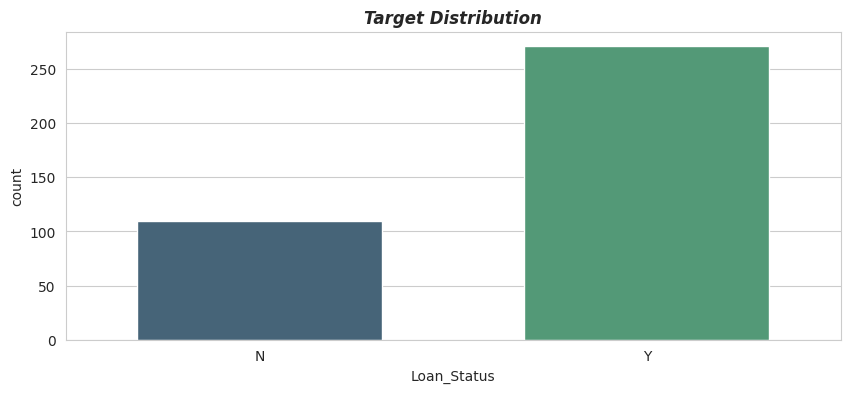

In [ ]:
plt.figure(figsize = (10, 4))
sns.countplot(x = data['Loan_Status'], palette = 'viridis', saturation = 0.54, width = 0.6323)
plt.title('Target Distribution', weight = 'bold', style = 'italic')
plt.show()

In [ ]:
print('Number of occurrences:  \n')
display(data['Loan_Status'].value_counts())

Number of occurrences:  



Loan_Status
Y    271
N    110
Name: count, dtype: int64

In [ ]:
print('Proportion in %: \n ')
display(data['Loan_Status'].value_counts(normalize = True))

Proportion in %: 
 


Loan_Status
Y    0.711286
N    0.288714
Name: proportion, dtype: float64

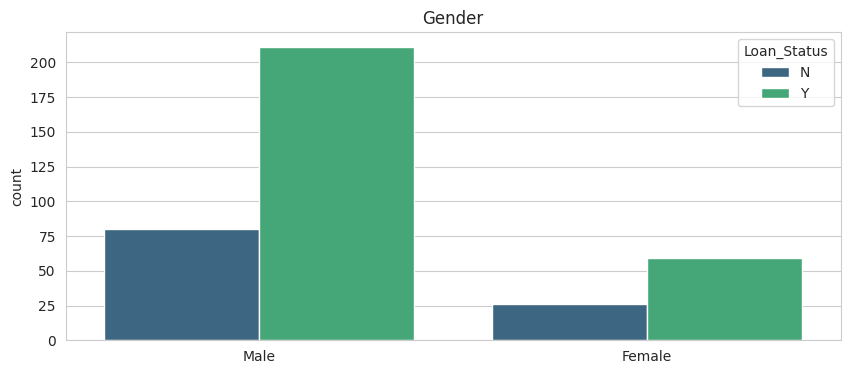

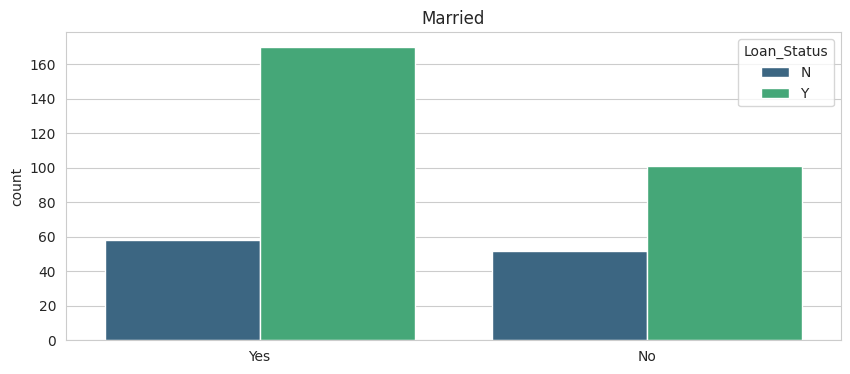

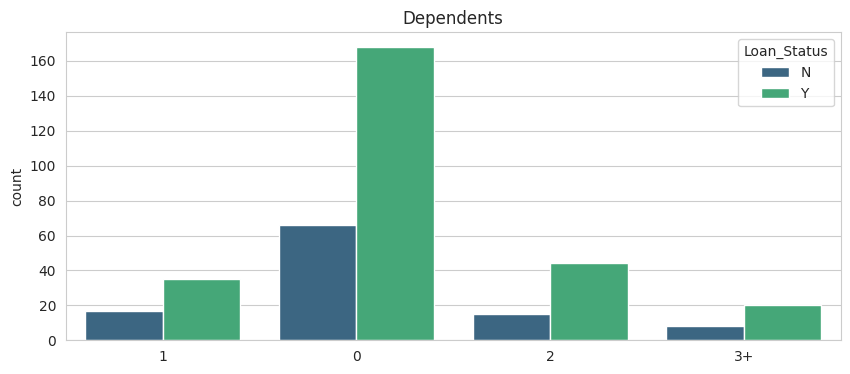

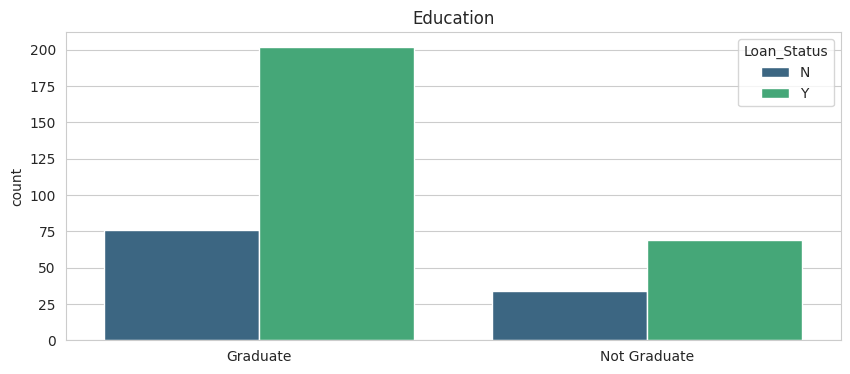

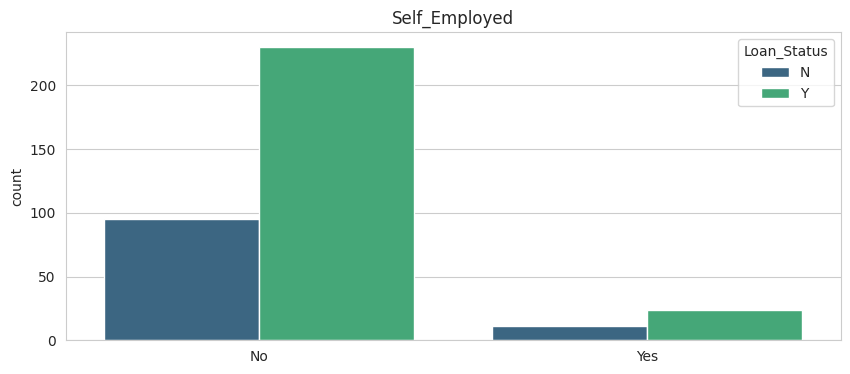

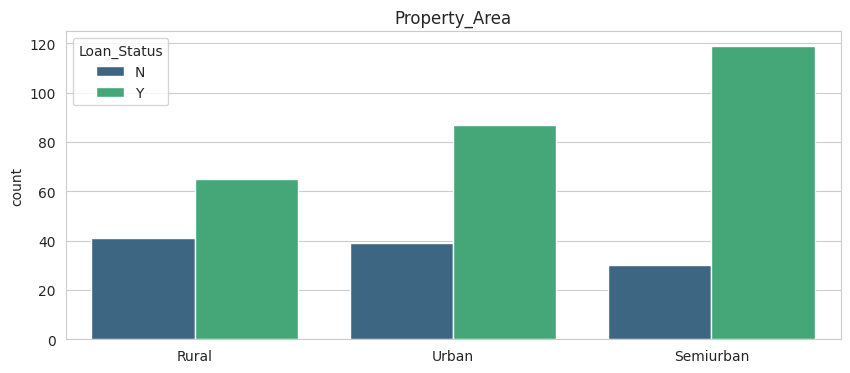

In [ ]:
for col in data.drop(['Loan_ID', 'Loan_Status'],axis = 1).select_dtypes('O').columns:
    plt.figure(figsize = (10, 4))
    sns.countplot(data =data, x = col, hue = 'Loan_Status', palette = 'viridis')
    plt.xlabel(None)
    plt.title(col)
    plt.show()

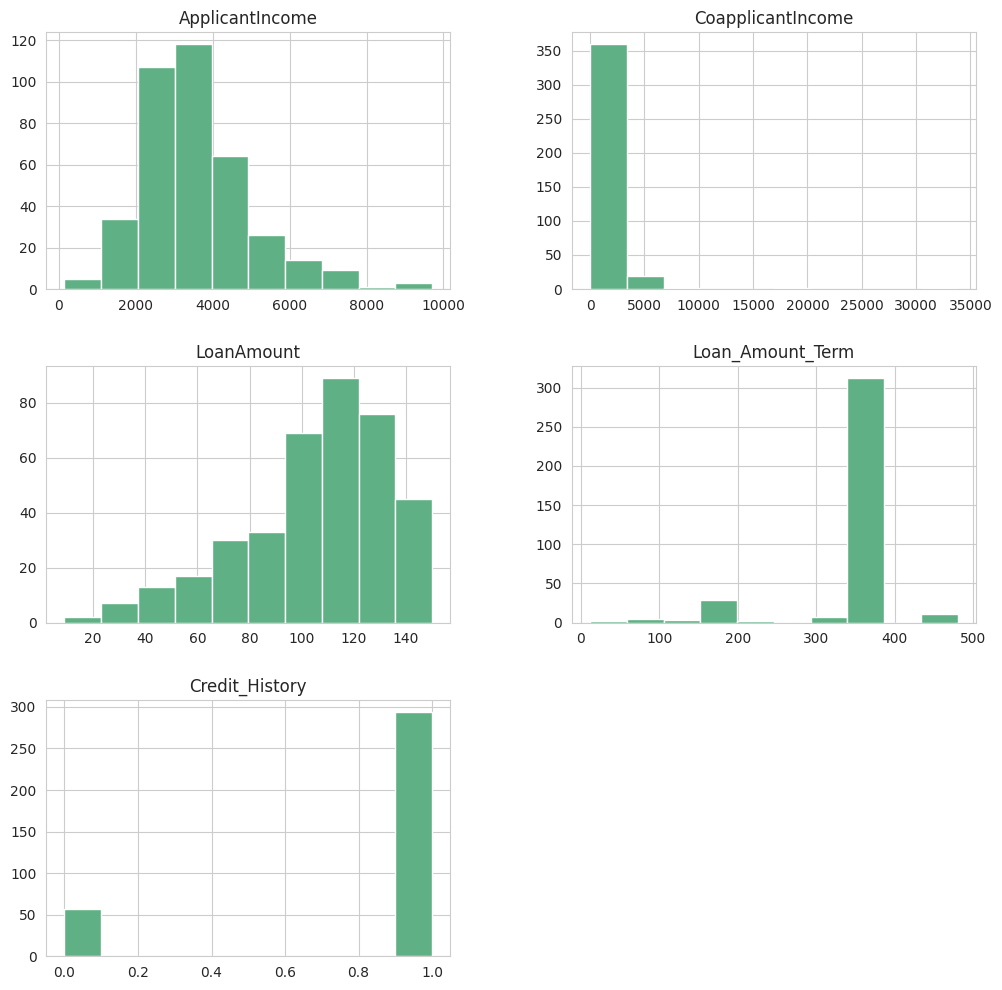

In [ ]:
data.select_dtypes(np.number).hist(figsize = (12, 12), color = '#5fb085');

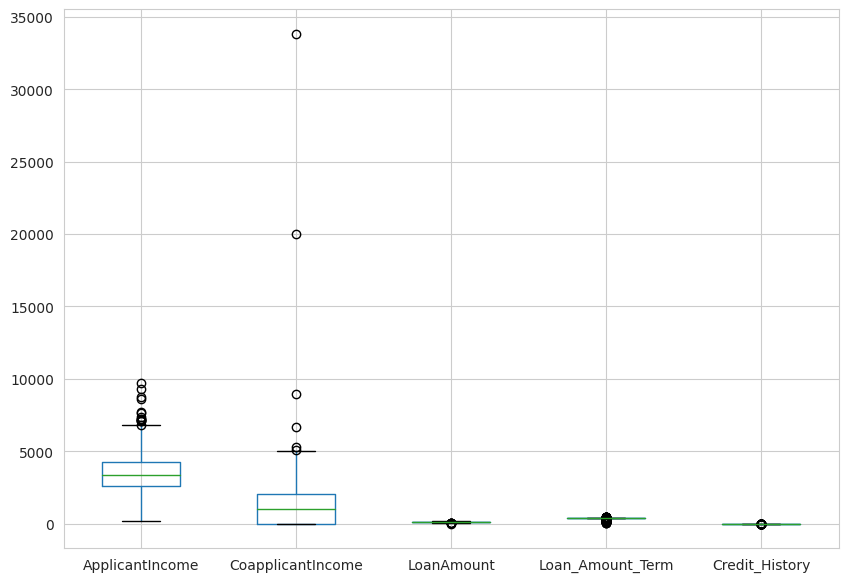

In [ ]:
data.select_dtypes(np.number).boxplot(figsize = (10, 7));

<Figure size 800x800 with 0 Axes>

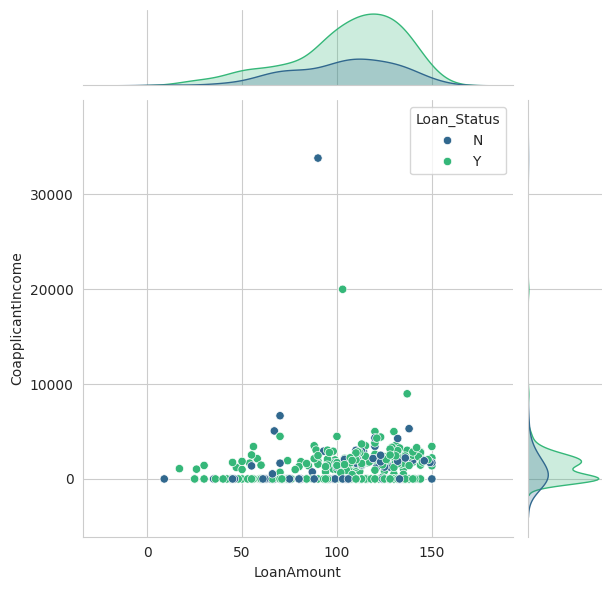

<Figure size 800x800 with 0 Axes>

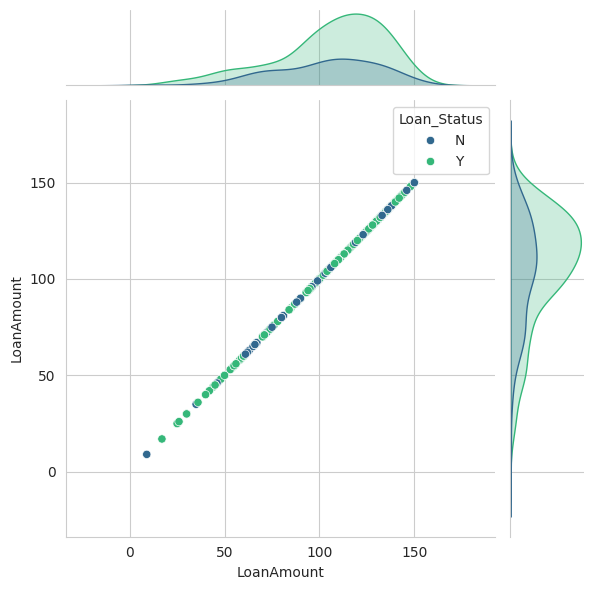

<Figure size 800x800 with 0 Axes>

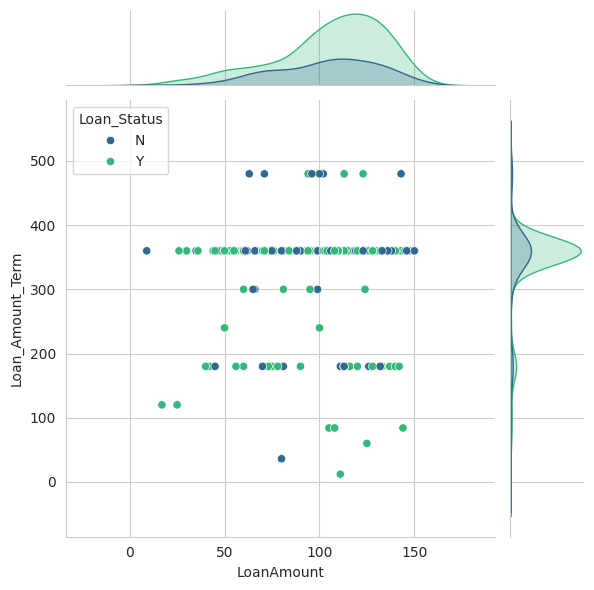

<Figure size 800x800 with 0 Axes>

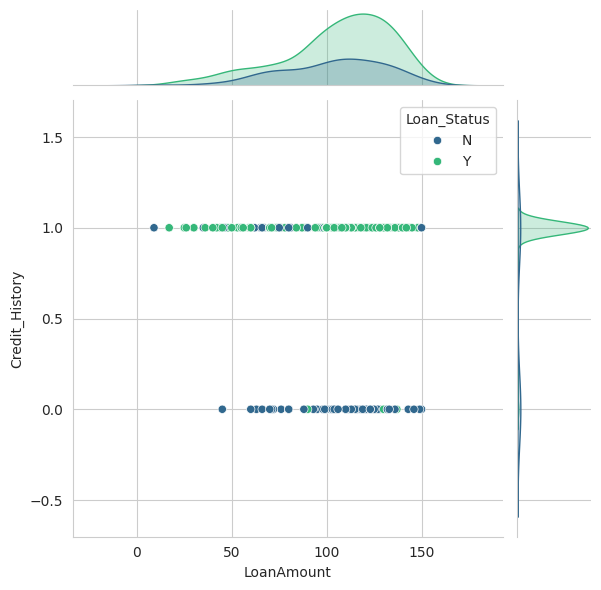

In [ ]:
for col in data.select_dtypes(np.float64).columns:

    plt.figure(figsize = (8, 8))
    sns.jointplot(data, x = 'LoanAmount', y = col, hue = 'Loan_Status', palette = 'viridis')
    plt.show()

# Data Split

In [ ]:
X = data.drop('Loan_Status', axis = 1)
y = data['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.15, random_state = 0)

X_train.shape, X_test.shape

((323, 12), (58, 12))

# Feature Engineering

In [ ]:
X_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
208,LP002086,Female,Yes,0,Graduate,No,4333,2451.0,110.0,360.0,1.0,Urban
72,LP001370,Male,No,0,Not Graduate,NaN,7333,0.0,120.0,360.0,1.0,Rural
86,LP001489,Female,Yes,0,Graduate,No,4583,0.0,84.0,360.0,1.0,Rural
62,LP001316,Male,Yes,0,Graduate,No,2958,2900.0,131.0,360.0,1.0,Semiurban
285,LP002443,Male,Yes,2,Graduate,No,3340,1710.0,150.0,360.0,0.0,Rural


In [ ]:
X_train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
dtype: object

In [ ]:
X_train.isnull().sum()

Loan_ID               0
Gender                2
Married               0
Dependents            8
Education             0
Self_Employed        19
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     10
Credit_History       24
Property_Area         0
dtype: int64

In [ ]:
def feature_engineering(X_train, X_test, y_train):

    categorical_imputation = CategoricalImputer(imputation_method='frequent', variables = ['Gender', 'Dependents', 'Self_Employed'])
    numerical_imputation = MeanMedianImputer(imputation_method='median', variables = ['Loan_Amount_Term', 'Credit_History'])

    categorical_encoder = OrdinalEncoder(variables = ['Gender', 'Married', 'Education', 'Dependents', 'Self_Employed', 'Property_Area'], encoding_method='arbitrary')



    X_train = categorical_imputation.fit_transform(X_train)
    X_train = numerical_imputation.fit_transform(X_train)
    X_train = categorical_encoder.fit_transform(X_train, y_train)

    X_test = categorical_imputation.transform(X_test)
    X_test = numerical_imputation.transform(X_test)
    X_test = categorical_encoder.transform(X_test)

    X_train['Credit_History'] = X_train['Credit_History'].astype(np.int64)
    X_test['Credit_History'] = X_test['Credit_History'].astype(np.int64)

    X_train.drop('Loan_ID', axis = 1, inplace = True)
    X_test.drop('Loan_ID', axis = 1, inplace = True)

    return X_train, X_test

In [ ]:
X_train_encoded, X_test_encoded = feature_engineering(X_train, X_test, y_train)

In [ ]:
X_train_encoded

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
208,0,0,0,0,0,4333,2451.0,110.0,360.0,1,0
72,1,1,0,1,0,7333,0.0,120.0,360.0,1,1
86,0,0,0,0,0,4583,0.0,84.0,360.0,1,1
62,1,0,0,0,0,2958,2900.0,131.0,360.0,1,2
285,1,0,1,0,0,3340,1710.0,150.0,360.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
70,1,0,1,1,0,4288,3263.0,133.0,180.0,1,0
233,0,1,0,0,0,2764,1459.0,110.0,360.0,1,0
100,0,0,0,0,0,4583,0.0,112.0,360.0,1,1
87,1,0,1,0,1,3316,3500.0,88.0,360.0,1,0


In [ ]:
rf = RandomForestClassifier(random_state = 0)

rf.fit(X_train_encoded, y_train)

print('Accuracy on the train set: {:.5f}'.format(rf.score(X_train_encoded, y_train)))
print('accuracy on the test set: {:.5f}'.format(rf.score(X_test_encoded, y_test)))

Accuracy on the train set: 1.00000
accuracy on the test set: 0.81034


In [ ]:
y_pred = rf.predict(X_test_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.75      0.53      0.62        17
           Y       0.83      0.93      0.87        41

    accuracy                           0.81        58
   macro avg       0.79      0.73      0.75        58
weighted avg       0.80      0.81      0.80        58



In [ ]:
y_pred_prob = rf.predict_proba(X_test_encoded)[:, 1]
print('AUC score: {:.5f}'.format(roc_auc_score(y_test, y_pred_prob)))

AUC score: 0.89742


In [ ]:
columns_to_scale = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

scaler = MinMaxScaler()
scaler.set_output(transform='pandas')

X_train_scaled = X_train_encoded.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_encoded[columns_to_scale])

X_test_scaled = X_test_encoded.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test_encoded[columns_to_scale])

In [ ]:
X_train_scaled.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
208,0,0,0,0,0,0.437873,0.072435,0.716312,0.74359,1,0
72,1,1,0,1,0,0.751910,0.000000,0.787234,0.74359,1,1
86,0,0,0,0,0,0.464043,0.000000,0.531915,0.74359,1,1
62,1,0,0,0,0,0.293939,0.085705,0.865248,0.74359,1,2
285,1,0,1,0,0,0.333927,0.050536,1.000000,0.74359,0,1


In [ ]:
svm = SVC(random_state = 0, probability=True)

svm.fit(X_train_scaled, y_train)

print('Accuracy on the train set: {:.5f}'.format(svm.score(X_train_scaled, y_train)))
print('accuracy on the test set: {:.5f}'.format(svm.score(X_test_scaled, y_test)))

Accuracy on the train set: 0.84211
accuracy on the test set: 0.86207


In [ ]:
y_pred = svm.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       1.00      0.53      0.69        17
           Y       0.84      1.00      0.91        41

    accuracy                           0.86        58
   macro avg       0.92      0.76      0.80        58
weighted avg       0.88      0.86      0.85        58



In [ ]:
y_pred_prob = svm.predict_proba(X_test_scaled)[:, 1]
print('AUC score: {:.5f}'.format(roc_auc_score(y_test, y_pred_prob)))

AUC score: 0.77044


In [ ]:
ada = AdaBoostClassifier(random_state = 0)

ada.fit(X_train_encoded, y_train)

print('Accuracy on the train set: {:.5f}'.format(ada.score(X_train_encoded, y_train)))
print('accuracy on the test set: {:.5f}'.format(ada.score(X_test_encoded, y_test)))

Accuracy on the train set: 0.88854
accuracy on the test set: 0.79310


In [ ]:
y_pred = ada.predict(X_test_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.67      0.59      0.62        17
           Y       0.84      0.88      0.86        41

    accuracy                           0.79        58
   macro avg       0.75      0.73      0.74        58
weighted avg       0.79      0.79      0.79        58



In [ ]:
y_pred_prob = ada.predict_proba(X_test_encoded)[:, 1]
print('AUC score: {:.5f}'.format(roc_auc_score(y_test, y_pred_prob)))

AUC score: 0.85079


In [ ]:
for column in X_train_encoded.columns:
    rf = RandomForestClassifier(random_state = 0)

    rf.fit(X_train_encoded[[column]], y_train)
    print(f'AUC score of the {column} column: ')
    auc = roc_auc_score(y_test, rf.predict_proba(X_test_encoded[[column]])[:, 1])
    print(auc)

    print('=' * 40)
    print('\n')

AUC score of the Gender column: 
0.5494978479196557


AUC score of the Married column: 
0.5035868005738882


AUC score of the Dependents column: 
0.4569583931133429


AUC score of the Education column: 
0.4591104734576758


AUC score of the Self_Employed column: 
0.5272596843615495


AUC score of the ApplicantIncome column: 
0.6649928263988523


AUC score of the CoapplicantIncome column: 
0.5473457675753228


AUC score of the LoanAmount column: 
0.4885222381635581


AUC score of the Loan_Amount_Term column: 
0.5358680057388809


AUC score of the Credit_History column: 
0.7647058823529411


AUC score of the Property_Area column: 
0.5459110473457676




# Model Tuning

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt']),  # Modified this line
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }

    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train_encoded, y_train)

    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)

    return auc

# Criar um estudo Optuna
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed = 33))
study.optimize(objective, n_trials=100)

[I 2024-05-02 14:02:59,653] A new study created in memory with name: no-name-1bb150a6-cacc-445a-8137-ecf7be3a703a
[I 2024-05-02 14:03:00,991] Trial 0 finished with value: 0.8823529411764706 and parameters: {'n_estimators': 323, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.8823529411764706.
[I 2024-05-02 14:03:04,661] Trial 1 finished with value: 0.8751793400286945 and parameters: {'n_estimators': 969, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8823529411764706.
[I 2024-05-02 14:03:06,447] Trial 2 finished with value: 0.8895265423242468 and parameters: {'n_estimators': 749, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8895265423242468.
[I 2024-

In [ ]:
print('Best AUC score: {:.5f}'.format(study.best_value))

Best AUC score: 0.93400


In [ ]:
print('Best Params: ')
rf_params = study.best_params
rf_params

Best Params: 


{'n_estimators': 238,
 'max_depth': 13,
 'min_samples_split': 11,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'bootstrap': True,
 'criterion': 'entropy'}

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
def objective(trial):

    params = {
        'C': trial.suggest_loguniform('C', 1e-4, 1e4),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'probability': True,
    }

    model = SVC(**params, random_state = 42)
    model.fit(X_train_scaled, y_train)

    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)

    return auc

study = optuna.create_study(direction='maximize', sampler = TPESampler(seed = 33))
study.optimize(objective, n_trials=100)

[I 2024-05-02 14:06:08,746] A new study created in memory with name: no-name-bf27433f-154b-44cf-91b0-e6231f0559fb
[I 2024-05-02 14:06:08,825] Trial 0 finished with value: 0.697274031563845 and parameters: {'C': 0.009729287108797028, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with value: 0.697274031563845.
[I 2024-05-02 14:06:09,436] Trial 1 finished with value: 0.6657101865136299 and parameters: {'C': 4226.844315317394, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.697274031563845.
[I 2024-05-02 14:06:09,500] Trial 2 finished with value: 0.776183644189383 and parameters: {'C': 0.0020374234519644936, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 2 with value: 0.776183644189383.
[I 2024-05-02 14:06:09,531] Trial 3 finished with value: 0.8694404591104734 and parameters: {'C': 0.009597238233662318, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 3 with value: 0.8694404591104734.
[I 2024-05-02 14:06:09,570] Trial 4 finished with value: 0.6255380200

In [ ]:
print('Best AUC score: {:.5f}'.format(study.best_value))

Best AUC score: 0.86944


In [ ]:
print('Best Params: ')
svm_params = study.best_params
svm_params

Best Params: 


{'C': 0.009597238233662318, 'kernel': 'linear', 'gamma': 'scale'}

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R'])
    }

    model = AdaBoostClassifier(**params, random_state = 42)
    model.fit(X_train_encoded, y_train)

    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)

    return auc

study = optuna.create_study(direction='maximize', sampler = TPESampler(seed = 33))
study.optimize(objective, n_trials=100)

[I 2024-05-02 14:09:35,146] A new study created in memory with name: no-name-a2958f4d-05b6-4c39-87a1-1ea86243ca1d
[I 2024-05-02 14:09:35,938] Trial 0 finished with value: 0.855093256814921 and parameters: {'n_estimators': 286, 'learning_rate': 0.022383410687462493, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.855093256814921.
[I 2024-05-02 14:09:38,801] Trial 1 finished with value: 0.8579626972740315 and parameters: {'n_estimators': 877, 'learning_rate': 0.0035902094150256606, 'algorithm': 'SAMME.R'}. Best is trial 1 with value: 0.8579626972740315.
[I 2024-05-02 14:09:40,496] Trial 2 finished with value: 0.8644189383070301 and parameters: {'n_estimators': 697, 'learning_rate': 0.028824672368677088, 'algorithm': 'SAMME'}. Best is trial 2 with value: 0.8644189383070301.
[I 2024-05-02 14:09:40,744] Trial 3 finished with value: 0.8651362984218077 and parameters: {'n_estimators': 125, 'learning_rate': 0.011329800775348854, 'algorithm': 'SAMME.R'}. Best is trial 3 with value: 0.86513

In [ ]:
print('Best AUC score: {:.5f}'.format(study.best_value))

Best AUC score: 0.91966


In [ ]:
print('Best Params: ')
ada_params = study.best_params
ada_params

Best Params: 


{'n_estimators': 410,
 'learning_rate': 0.13278561170916361,
 'algorithm': 'SAMME.R'}

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
ada = AdaBoostClassifier(**ada_params, random_state = 42)

ada.fit(X_train_encoded, y_train)

y_pred = ada.predict(X_test_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.75      0.53      0.62        17
           Y       0.83      0.93      0.87        41

    accuracy                           0.81        58
   macro avg       0.79      0.73      0.75        58
weighted avg       0.80      0.81      0.80        58



In [ ]:
roc_auc_score(y_test, ada.predict_proba(X_test_encoded)[:, 1])

0.9196556671449068

In [ ]:
def plot_comparison(y_train, y_resampled):

    plt.figure(figsize = (10, 5))
    sns.countplot(x = y_train, palette = 'viridis')
    plt.title('Before Resampling')
    plt.show()

    print('\n')

    plt.figure(figsize = (10, 5))
    sns.countplot(x = y_resampled, palette = 'viridis')
    plt.title('After Resampling')
    plt.show()

In [ ]:
svmsmote = SVMSMOTE(sampling_strategy='auto', svm_estimator = SVC(**svm_params, random_state = 42), random_state = 0)

X_train_resampled, y_resampled = svmsmote.fit_resample(X_train_encoded, y_train)

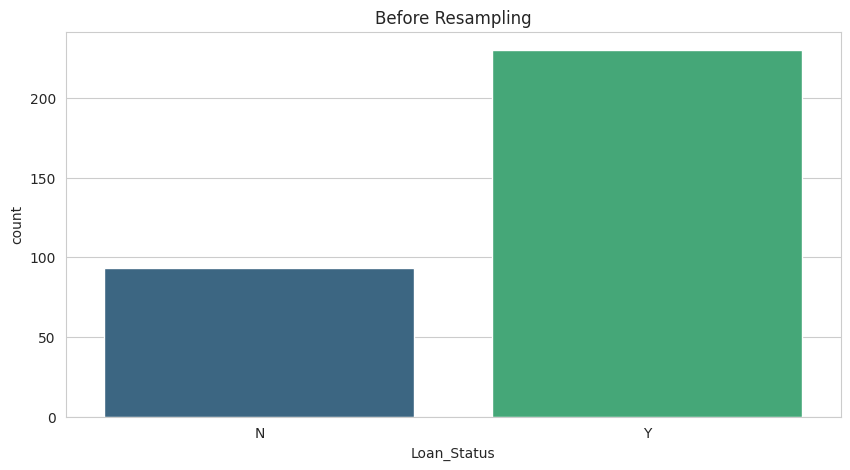

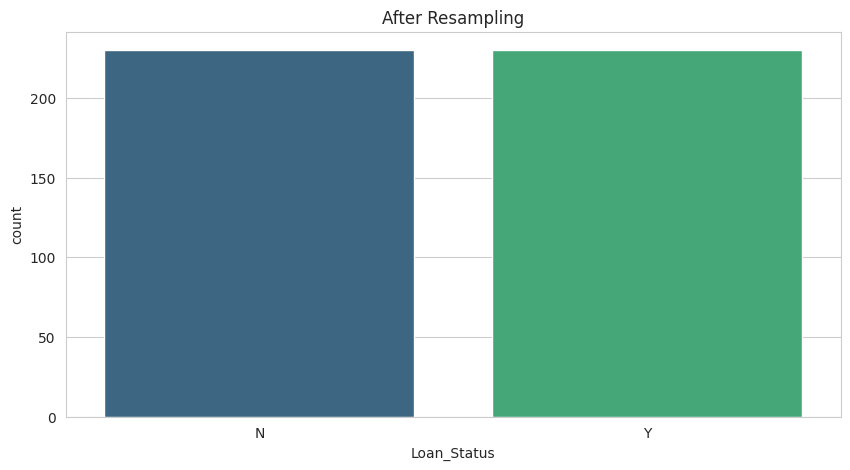

In [ ]:
plot_comparison(y_train, y_resampled)

In [ ]:
ada = AdaBoostClassifier(**ada_params, random_state = 42)

ada.fit(X_train_resampled, y_resampled)

y_pred = ada.predict(X_test_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.71      0.71      0.71        17
           Y       0.88      0.88      0.88        41

    accuracy                           0.83        58
   macro avg       0.79      0.79      0.79        58
weighted avg       0.83      0.83      0.83        58



In [ ]:
roc_auc_score(y_test, ada.predict_proba(X_test_encoded)[:, 1])

0.8931133428981348

In [ ]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)

total_samples = len(y_train)
class_weights = {cls: total_samples / count for cls, count in zip(unique_classes, class_counts)}

print("Weights:", class_weights)

Weights: {'N': 3.4731182795698925, 'Y': 1.4043478260869566}


In [ ]:
class_weights = {'N': 3.4731182795698925, 'Y': 1.4043478260869566}

ada = AdaBoostClassifier(**ada_params, random_state = 42)
ada.fit(X_train_encoded, y_train, sample_weight=[class_weights[i] for i in y_train])

y_pred = ada.predict(X_test_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.67      0.94      0.78        17
           Y       0.97      0.80      0.88        41

    accuracy                           0.84        58
   macro avg       0.82      0.87      0.83        58
weighted avg       0.88      0.84      0.85        58



In [ ]:
roc_auc_score(y_test, ada.predict_proba(X_test_encoded)[:, 1])

0.9196556671449068

In [ ]:
bag = BaggingClassifier(estimator = AdaBoostClassifier(**ada_params, random_state = 42), n_estimators = 5, random_state = 0)

bag.fit(X_train_encoded, y_train)

y_pred = bag.predict(X_test_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.92      0.71      0.80        17
           Y       0.89      0.98      0.93        41

    accuracy                           0.90        58
   macro avg       0.91      0.84      0.87        58
weighted avg       0.90      0.90      0.89        58



In [ ]:
roc_auc_score(y_test, bag.predict_proba(X_test_encoded)[:, 1])

0.9296987087517934